In [25]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import prep_for_model_runs as prep
import model_params_class as mp
import run_models as run
import sys
sys.path.append('../')

In [26]:
import sys
!conda install --yes --prefix {sys.prefix} matplotlib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Deterministic SIR model for multi-groups 
See: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4002176/


The model works like this: 
- Let's say we have N groups with size n_0 .... n_N
- Define four vectors (S = 'Susceptible, I = Infected, R = Recovered, D = Died) for each of the groups
    - for example: $\vec{I} = < I_0, I_1 \dots I_N >$ is the vector for the number of currently infected people in each subpopulation
- Assume a "contact matrix" $C = c_{ij} $ where $c_{ij}$ is the expected rate of contacts between groups i and j.
    - for example if $c_{i,j}$ = 0.1 that means that average number of contacts that an individual in group i has with group j is 0.1 --> i.e. there is a 1/10 chance they see anyone 
- Assume a "transmission matrix" $T = t_{ij}$ where $t_{ij}$  is the expected transmission between groups i and j if they make contact
    - The following code assumes that this is 1 (e.g. transmission rate is rolled into contact matrix) and is constant across groups. 
    - In a more sophisticated model, this assumption is not true. The transmission rate should not even be reciprocal. For example, if police are wearing masks when they interact with a community member, but there hands are equipment are dirty transmission rate could be higher in one direction. Transmission rate could also be higher for different types of interactions
- $\vec{\gamma}$ is the recovery rate .. e.g. $\gamma_i$ the likelihood that on a given day a sick person in group i recovers. We are using 1/14
- $\vec{\mu}$ is the death rate (divided by average disease duration) for each group

Combining contact and transmission, we can define a vector $\vec{\lambda}$ where $\lambda_i$ is the new infection rate (called the force of infection in the literature). 

- Force of infection = contact x transmission or $\lambda_i = \sum_j^N c_{ij} * t_{ij} $

Given $\vec{\lambda}$ the vector with contact rate * transmission rate, we can define our differential equations as follows:(Note that $t$ is current time and $t-1$ is previous time point. 

- Sub population totals : $\vec{N} = \vec{I_t} + \vec{R_t} + \vec{S_t} + \vec{D_t}$
- Susceptible number of people by sup-population: $\vec{S_t} = \vec{S_{t-1}} - \vec{I_{t-1}}$
- Infected by subpopulation $\vec{I_t} = \vec{I_{t-1}}+  \vec{\lambda} * \vec{S_{t-1}} * \frac{\vec{I_{t-1}}}{\vec{N}} - \vec{\gamma} \vec{I_{t-1}} - \vec{\mu} \vec{I_{t-1}}$ 
    - $\vec{I_t} =$ infected people before + newly infected people - infected people who recover
    - newly infected people = susceptible population * contact rate * transmission rate * proportion of population infected 
    - $\frac{\vec{I_{t-1}}}{\vec{N}}$ is the proportion of members of each group that are infected
- Recovered by Group: $\vec{R_t} = \vec{R_{t-1}} + \vec{\gamma} \vec{I_{t-1}}$

The implementation of this model does not try to count the number of individuals who have died, which simplifies it. 

In [28]:
color_matrix = {'White': 'k',
                'White_Forced_Labour' : 'r',
                'Black' : 'g',
                'Black_Forced_Labour': 'b',
                'Black_Prison' : 'k',
                'White_Police' : 'o',
                'Black_Police' : 'p',
                'White_Prison': 'y',
                'Total_Residents': 'g'}

In [29]:
def clean_df_names(df):
    df.columns = df.columns.str.strip()
    df.index = df.index.map(lambda s: s.strip())
    return df

In [75]:
"""Run multiple versions of the model, varying certain parameters to quantify uncertainty

params
------
base_dir: String
    the name of the directory where contact matrices and group size matrices are stored
    
starting_params: object of class ModelParams
    contains the initial parameters for the original model run
    
prison_peak_date: Int
    the day on which the prison infection rate peaks
    
days: Int
    the number of days to run the model for
    
returns
-------
monster_summary_stats: a DataFrame of all of the summary statistics for the model runs
infection_maps: a dictionary where the keys are stylized versions of a list of the starting parameters and the 
    values are infection_df's generated by these combinations of starting parameters
pd.concat(pop_sizes): a DataFrame that is a stacked version of all pop_size_df's output by the various model runs
"""
def run_with_uncertainty(base_dir, starting_params, prison_peak_date, days):
    monster_summary_stats = pd.DataFrame({})
    infection_maps = {}
    pop_sizes = []
    #  In our original model run, the peak prison infection rate is 0.35, the number of daily police contacts is
    #  10, and the number of patrol police officers per 10K residents is ~ 16
    for prison_infection_rate in [.35]:
        for pc in [10]:
            for pgrp in [17]:
    #  We examined other parameters to get bounds on uncertainty. 
#     for prison_infection_rate in [25, .35, .45]:
#         for pc in [5, 7.5, 10, 12.5,15]:
#             for pgrp in [13.8, 14.9, 16, 17, 18.2]:
                
                params = starting_params.add_uncertainty_params(prison_infection_rate, pc, pgrp)
                
                # # get contact matrix
                # contact_data_post_sip = pd.read_csv(
                #     os.path.join(base_dir, prep.get_CONTACT_MATRIX_POST_LOCKDOWN(pc, pgrp)), 
                #     index_col=0)
                contact_data_post_sip = pd.read_csv(os.path.join(base_dir, CONTACT_MATRIX_PATH), index_col=0).set_index('Group_Name')
                
  
                # contact_data_pre_SIP = clean_df_names(pd.read_csv(os.path.join(base_dir, prep.get_CONTACT_MATRIX_PRE_LOCKDOWN(pc,pgrp)),
                #                                    index_col=0))
                contact_data_pre_SIP = clean_df_names(pd.read_csv(
                    os.path.join(base_dir, PRE_SOCIAL_DISTANCE_CONTACT_MATRIX),index_col = 0).set_index('Group_Name'))



                # group_size_data = clean_df_names(pd.read_csv(
                #     os.path.join(base_dir,prep.get_GROUP_SIZE_PATH(params.police_group_size))).set_index('Group'))
                #
                group_size_data = pd.read_csv(os.path.join(base_dir, GROUP_SIZE_PATH),
                                              index_col = 0)
                print(group_size_data.columns)
                # eq_group_size_data = clean_df_names(pd.read_csv(
                #     os.path.join(base_dir, prep.get_GROUP_SIZE_EQ_PATH(params.police_group_size))).set_index('Group'))

                #eq_group size should be removed
                eq_group_size_data = group_size_data
                
                ## Should be modified so it take a list of policy intervention SIP and Pre SIP matrices. 
                summary, infection_df, pop_size_df = run.run_models(
                    base_dir, params, days, group_size_data,
                    eq_group_size_data,contact_data_pre_SIP,
                    contact_data_post_sip, prison_peak_date)                                             

                infection_maps[params.get_name()] = infection_df
                pop_sizes.append(pop_size_df)
                
                summary['Initial_Infections'] = starting_params.initial_infection_multiplier
                summary['Lockdown_Date'] = starting_params.sip_start_date
                summary['Prison_Rate'] = starting_params.prison_infection_rate
                summary['Police_Contact_Rate'] = pc
                summary['Police_Group_Size'] = pgrp 
                monster_summary_stats= monster_summary_stats.append(summary)
    return monster_summary_stats, infection_maps, pd.concat(pop_sizes)
    

In [76]:
# Initial Input Parameters
PRISON_PEAK_DATE = 35
TRANSMISSION_RATE = 0.015
SIP_START_DATE  = 14
INITIAL_INFECTION_RATE =10
BASE_DIR = '../input2'
OUTPUT_DIR = 'output/'  #input2/CONTACT_MATRIX_POST_SIP.csv
CONTACT_MATRIX_PATH = 'CONTACT_MATRIX_POST_SIP.csv'
PRE_SOCIAL_DISTANCE_CONTACT_MATRIX = "CONTACT_MATRIX_PRE_SIP.csv"
GROUP_SIZE_PATH = 'GROUP_SIZE.csv'
DAYS = 120

In [77]:
#writing the matrices, we could return them so we wouldn't need to read them again 
import generate_matrix
generate_matrix.write_matrices()

In [78]:
starting_params = mp.ModelParams(TRANSMISSION_RATE, SIP_START_DATE, INITIAL_INFECTION_RATE)
full_summary_stats, infection_maps, pop_sizes = run_with_uncertainty(
    BASE_DIR, starting_params, PRISON_PEAK_DATE, DAYS)

Index(['Population_Proportion', 'Population_Size', 'Initial_Infection_Rate',
       'Initial_Infections'],
      dtype='object')


In [79]:
full_summary_stats.head()

,model_tag,cumulative_infected_40_days,cumulative_rate_40_days,active_rate_before_peak,cumulative_before_peak,cumulative_rate_before_peak,days_peak,peak_active_infected_rate,cumulative_peak,cumulative_rate_peak,active_rate_after_peak,cumulative_after_peak,cumulative_rate_after_peak,model_name,Initial_Infections,Lockdown_Date,Prison_Rate,Police_Contact_Rate,Police_Group_Size
Black,I10_PI0.35_L14___pc10_pgrp17,152510.0,0.197617,0.433499,371291.0,0.481106,52,0.476824,454474.0,0.588892,0.476824,454474.0,0.588892,original,10,14,0.35,10,17
Black_Forced_Labour,I10_PI0.35_L14___pc10_pgrp17,88614.0,0.485535,0.732019,157980.0,0.865606,48,0.732019,157980.0,0.865606,0.634896,170420.0,0.933767,original,10,14,0.35,10,17
White,I10_PI0.35_L14___pc10_pgrp17,786707.0,0.207018,0.336611,1474005.0,0.387877,50,0.344640,1621056.0,0.426572,0.332518,1757221.0,0.462403,original,10,14,0.35,10,17
White_Forced_Labour,I10_PI0.35_L14___pc10_pgrp17,332532.0,0.489377,0.712633,576452.0,0.848347,48,0.712633,576452.0,0.848347,0.611231,624766.0,0.919450,original,10,14,0.35,10,17
Total_Residents,I10_PI0.35_L14___pc10_pgrp17,1360363.0,0.250345,0.410672,2579728.0,0.474743,50,0.416431,2808822.0,0.516903,0.398021,3006881.0,0.553352,original,10,14,0.35,10,17


In [80]:
#Write Output

os.makedirs(OUTPUT_DIR)
pop_sizes.to_csv('group_sizes.csv')

In [81]:
sum_stats_path = os.path.join(OUTPUT_DIR, 'all_model_summary_stats.csv')
full_summary_stats.to_csv(sum_stats_path)

In [82]:
# Graph one of the models so we can check on the group sizes 

In [88]:
i = infection_maps['I10_PI0.35_L14___pc10_pgrp17']

In [89]:
pop_for_model = pop_sizes[pop_sizes['name'] == 'I10_PI0.35_L14___pc10_pgrp17']
p = pop_for_model.loc['original']

In [90]:
# Look at the infection rates for just one racial group
i[i['model_name'] == 'original']['White']/p['White']

0      0.000055
1      0.000057
2      0.000070
3      0.000086
4      0.000108
         ...   
116    0.045212
117    0.043957
118    0.042737
119    0.041551
120    0.040398
Name: White, Length: 121, dtype: float64

In [91]:
# Look at the population sizes for one group
pop_sizes.head()

Group_Name,Black,Black_Forced_Labour,Black_Police,Black_Prison,White,White_Forced_Labour,White_Police,White_Prison,Total_Residents,Total_w_Police,name
original,771744.51294,182508.0,3644.8,14852.351039,3.800190e+06,679500.0,10137.8984,16647.648961,5.433943e+06,5.447725e+06,I10_PI0.35_L14___pc10_pgrp17
no_police,771744.51294,182508.0,3644.8,14852.351039,3.800190e+06,679500.0,10137.8984,16647.648961,5.433943e+06,5.447725e+06,I10_PI0.35_L14___pc10_pgrp17
no_prison,771744.51294,182508.0,3644.8,14852.351039,3.800190e+06,679500.0,10137.8984,16647.648961,5.433943e+06,5.447725e+06,I10_PI0.35_L14___pc10_pgrp17
no_prison_or_police,771744.51294,182508.0,3644.8,14852.351039,3.800190e+06,679500.0,10137.8984,16647.648961,5.433943e+06,5.447725e+06,I10_PI0.35_L14___pc10_pgrp17
eq_police,771744.51294,182508.0,3644.8,14852.351039,3.800190e+06,679500.0,10137.8984,16647.648961,5.433943e+06,5.447725e+06,I10_PI0.35_L14___pc10_pgrp17


In [92]:
# Make Some Plots to Visualize The Infection In the Synthetic City

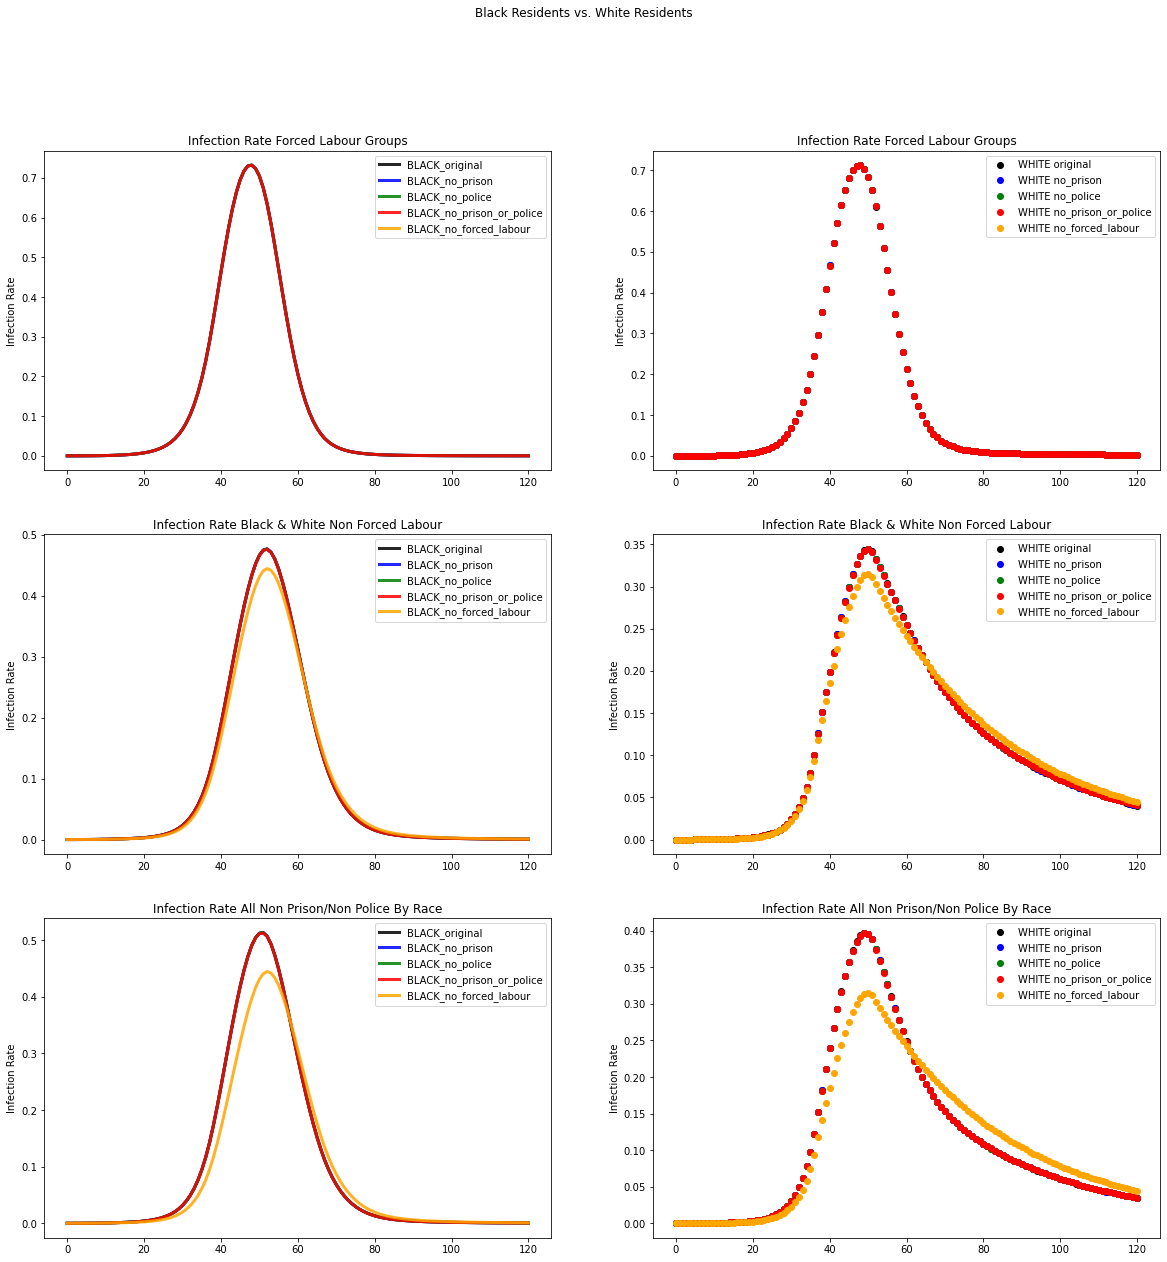

In [94]:
fig, ax  = plt.subplots(3, 2, figsize = (20, 20))
fig.suptitle("Black Residents vs. White Residents")

model_colors = {
    'original' : 'k',
   # 'eq_forced_labour': 'p',
    'no_prison': 'b',
    'no_police': 'g',
    'no_prison_or_police': 'r',
    'no_forced_labour' : 'orange'
}

for k in model_colors.keys():
    df = i[i['model_name'] == k]
    pop_size = pop_for_model.loc[k]
    #print(k + "   " + str(pop_size['Black_Forced_Labour']))
    x = df['Black_Forced_Labour']/pop_size['Black_Forced_Labour']
    y = df['Black']/pop_size['Black']
    z = (df['Black'] + df['Black_Forced_Labour'])/ (pop_size['Black'] + pop_size['Black_Forced_Labour'])

    ax[0, 0].plot(df.index, x , model_colors[k], alpha=0.85, lw=3, label = 'BLACK_' + k)
    ax[1,0].plot(df.index, y ,model_colors[k], alpha=0.85, lw=3, label='BLACK_' + k)
    ax[2,0].plot(df.index, z, model_colors[k], alpha =0.85, lw=3, label =  "BLACK_" + k)

    #if k in ['original', 'no_forced_labour']:
    z2 = (df['White'] + df['White_Forced_Labour'])/(pop_size['White'] + pop_size['White_Forced_Labour'])

    ax[0,1].scatter(
        df.index, df['White_Forced_Labour']/pop_size['White_Forced_Labour'],
                color = model_colors[k], lw = 1, label = 'WHITE '+k)
    ax[1,1].scatter(df.index, df['White']/pop_size['White'], color = model_colors[k], lw = 1, label = 'WHITE '+ k)
    ax[2,1].scatter(df.index, z2, color = model_colors[k], lw = 1, label = 'WHITE '+k)
    
for r in range(0, 3):
    for c in range(0,2):
        ax[r,c].set_ylabel('Infection Rate')
        ax[r,c].legend(loc = 'best')
       # ax[r,c].set_xlim(10, 100)
        ax[0,c].set_title('Infection Rate Forced Labour Groups')
        ax[1,c].set_title('Infection Rate Black & White Non Forced Labour')
        ax[2,c].set_title('Infection Rate All Non Prison/Non Police By Race')
      #  ax[2,c].set_ylim(0, 0.2)
        

plt.show()

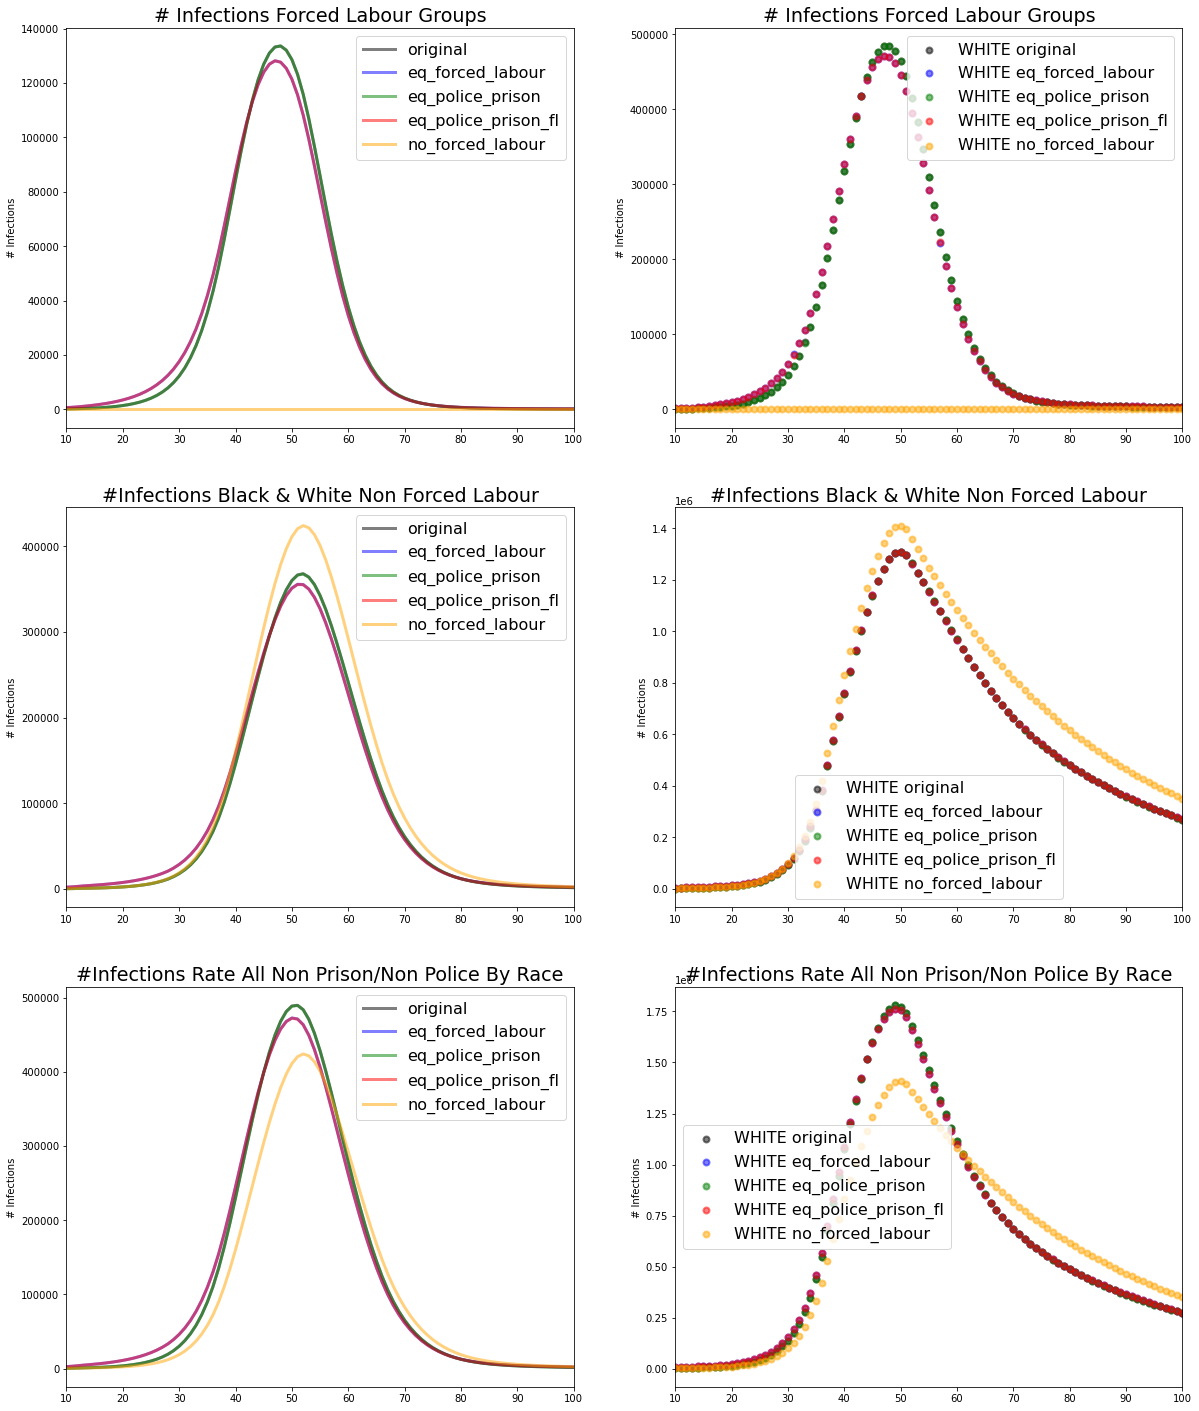

In [95]:
fig, ax = plt.subplots(3,2, figsize = (20, 25))
#fig.suptitle("Black Residents vs. White Residents")
plt.rc('font', size=16) 

model_colors = {
    'original' : 'k',
    'eq_forced_labour': 'b',
    'eq_police_prison': 'g',
    'eq_police_prison_fl': 'r',
    'no_forced_labour' : 'orange'
}
for k in model_colors.keys():
    df = i[i['model_name'] == k]
    pop_size = pop_for_model.loc[k]
    
    x = df['Black_Forced_Labour']
    y= df['Black']
    z = (df['Black'] + df['Black_Forced_Labour'])

    x2 = df['White_Forced_Labour']
    y2 = df['White'] 
    z2 = (df['White'] + df['White_Forced_Labour'])

    #/(pop_size['White'] + pop_size['White_Forced_Labour'])

    ax[0,0].plot(df.index, x , model_colors[k], alpha=0.5, lw=3, label=k+'')
    ax[1,0].plot(df.index, y ,model_colors[k], alpha=0.5, lw=3, label=k+'')
    ax[2,0].plot(df.index, z, model_colors[k], alpha = 0.5, lw = 3, label = k)

    #if k in ['original', 'eq_police_prison_fl']:
    ax[0,1].scatter(df.index, x2 , color = model_colors[k], alpha=0.5, lw=2, label='WHITE ' + k)
    ax[1,1].scatter(df.index, y2 ,color = model_colors[k], alpha=0.5, lw=2, label='WHITE ' + k)
    ax[2,1].scatter(df.index, z2, color = model_colors[k], alpha = 0.5, lw = 2, label ='WHITE ' + k)

for r in range(0, 3):
    for c in range(0,2):
        ax[r,c].set_ylabel('# Infections')
        ax[r,c].legend(loc = 'best')
        ax[r,c].set_xlim(10, 100)
        ax[0,c].set_title('# Infections Forced Labour Groups')
        ax[1,c].set_title('#Infections Black & White Non Forced Labour')
        ax[2,c].set_title('#Infections Rate All Non Prison/Non Police By Race')    

plt.show()